# DEEPFAKE DETECTION MODEL

## SETUP AND INSTALLATIONS

In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install facenet-pytorch
!pip install albumentations
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install tqdm
!pip install timm

INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torchaudio-2.6.0+cu124:
      Successfully uninstalled torchaudio-2.6.0+cu124


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTS AND SETUP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import json
import random
from tqdm import tqdm
import pickle
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import kagglehub
from kagglehub import KaggleDatasetAdapter

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Set random seeds for reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Check GPU availability

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## DIRECTORY SETUP

### Create project directories

In [ ]:
base_dir = '/content/drive/MyDrive/deepfake_detection'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/models', exist_ok=True)
os.makedirs(f'{base_dir}/results', exist_ok=True)

print("Project directories created successfully!")

Project directories created successfully!


## DATASET PREPARATION FUNCTIONS

In [ ]:
def extract_frames_from_video(video_path, max_frames=10, face_detector=None):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // max_frames)
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % step == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            if len(faces) > 0:
                largest_face = max(faces, key=lambda x: x[2] * x[3])
                x, y, w, h = largest_face
                padding = 20
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(frame.shape[1] - x, w + 2*padding)
                h = min(frame.shape[0] - y, h + 2*padding)
                face_crop = frame_rgb[y:y+h, x:x+w]
                if face_crop.size > 0:
                    frames.append(face_crop)
            del frame, frame_rgb, gray  # Explicitly free memory
        frame_idx += 1
        if len(frames) >= max_frames:
            break
    cap.release()
    return frames

## KAGGLE DATASET LOADING AND PROCESSING

In [1]:
def load_kaggle_ff_dataset():
    print("Loading FaceForensics++ dataset from Kaggle...")

    path = kagglehub.dataset_download("xdxd003/ff-c23")

    dataset_path = os.path.join(path, "FaceForensics++_C23")
    print(f"Contents of {dataset_path}: {os.listdir(dataset_path)}")

    return dataset_path

In [ ]:
def create_dataset_from_kaggle_ff(dataset_path, max_videos_per_class=200, max_frames_per_video=30):
    dataset = []
    labels = []

    # Define folder mappings
    real_folders = ['original']
    fake_folders = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

    print("Processing real videos...")
    # Process real videos
    for folder in real_folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi'))][:max_videos_per_class]

            print(f"Found {len(video_files)} videos in {folder}")

            for video_file in tqdm(video_files, desc=f"Processing {folder}"):
                video_path = os.path.join(folder_path, video_file)
                frames = extract_frames_from_video(video_path, max_frames_per_video)

                for frame in frames:
                    dataset.append(frame)
                    labels.append(0)  # Real = 0
        else:
            print(f"Warning: Folder {folder_path} not found")

    print(f"Processed real videos. Total real frames: {labels.count(0)}")

    print("Processing fake videos...")
    # Process fake videos
    for folder in fake_folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi'))][:max_videos_per_class]

            print(f"Found {len(video_files)} videos in {folder}")

            for video_file in tqdm(video_files, desc=f"Processing {folder}"):
                video_path = os.path.join(folder_path, video_file)
                frames = extract_frames_from_video(video_path, max_frames_per_video)

                for frame in frames:
                    dataset.append(frame)
                    labels.append(1)  # Fake = 1
        else:
            print(f"Warning: Folder {folder_path} not found")

    print(f"Processed fake videos. Total fake frames: {labels.count(1)}")
    print(f"Total dataset size: {len(dataset)} frames")

    return dataset, labels

def explore_kaggle_dataset(dataset_path):
    """Explore the structure of the Kaggle FaceForensics++ dataset"""
    print("Dataset Structure:")
    print("="*50)

    folders = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter',
               'FaceSwap', 'NeuralTextures', 'original', 'csv']

    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            if folder == 'csv':
                files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
                print(f"{folder}/: {len(files)} CSV files")
            else:
                video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi'))]
                print(f"{folder}/: {len(video_files)} videos")
        else:
            print(f"{folder_path}/: NOT FOUND")

    # Load and display CSV metadata if available
    csv_path = os.path.join(dataset_path, 'csv')
    if os.path.exists(csv_path):
        csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]
        if csv_files:
            print(f"\nFound CSV files: {csv_files}")
            # Load first CSV to see structure
            first_csv = os.path.join(csv_path, csv_files[0])
            try:
                df = pd.read_csv(first_csv)
                print(f"\nSample CSV structure ({csv_files[0]}):")
                print(df.head())
                print(f"CSV shape: {df.shape}")
            except Exception as e:
                print(f"Error reading CSV: {e}")

def create_balanced_dataset(dataset_path, samples_per_class=1000, max_frames_per_video=10):
    print(f"Creating balanced dataset with {samples_per_class} samples per class...")
    frame_paths = []
    labels = []
    output_dir = os.path.join(base_dir, 'data', 'frames')
    os.makedirs(output_dir, exist_ok=True)

    # Process real videos
    original_path = os.path.join(dataset_path, 'original')
    if os.path.exists(original_path):
        video_files = [f for f in os.listdir(original_path) if f.endswith(('.mp4', '.avi'))]
        for video_file in tqdm(video_files, desc="Processing real videos"):
            if len(frame_paths) >= samples_per_class:
                break
            video_path = os.path.join(original_path, video_file)
            frames = extract_frames_from_video(video_path, max_frames_per_video)
            for i, frame in enumerate(frames):
                if len(frame_paths) >= samples_per_class:
                    break
                frame_path = os.path.join(output_dir, f'real_{video_file}_{i}.jpg')
                cv2.imwrite(frame_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
                frame_paths.append(frame_path)
                labels.append(0)

    # Process fake videos
    fake_folders = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']
    for folder in fake_folders:
        if len(frame_paths) >= samples_per_class * 2:
            break
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi'))]
            for video_file in tqdm(video_files, desc=f"Processing {folder}"):
                if len(frame_paths) >= samples_per_class * 2:
                    break
                video_path = os.path.join(folder_path, video_file)
                frames = extract_frames_from_video(video_path, max_frames_per_video)
                for i, frame in enumerate(frames):
                    if len(frame_paths) >= samples_per_class * 2:
                        break
                    frame_path = os.path.join(output_dir, f'fake_{folder}_{video_file}_{i}.jpg')
                    cv2.imwrite(frame_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
                    frame_paths.append(frame_path)
                    labels.append(1)

# Shuffle data
    combined = list(zip(frame_paths, labels))
    random.shuffle(combined)
    frame_paths, labels = zip(*combined)
    print(f"Final dataset: {labels.count(0)} real + {labels.count(1)} fake = {len(frame_paths)} total")
    return list(frame_paths), list(labels)

    # Combine and shuffle
    all_frames = real_frames + fake_frames
    all_labels = real_labels + fake_labels

    # Check if any data was loaded
    if not all_frames:
        print("Error: No frames were extracted from the dataset. Check dataset path and content.")
        return [], [] # Return empty lists

    # Shuffle the data
    combined = list(zip(all_frames, all_labels))
    random.shuffle(combined)
    all_frames, all_labels = zip(*combined)

    print(f"Final dataset: {len(real_frames)} real + {len(fake_frames)} fake = {len(all_frames)} total")

    return list(all_frames), list(all_labels)

## CUSTOM DATASET CLASS

In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, torch.tensor(label, dtype=torch.float32)

## DATA AUGMENTATION

### Training transforms with strong augmentation

In [ ]:
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

### Validation transforms (no augmentation)

In [ ]:
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

## MODEL DEFINITION

In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self, model_name='efficientnet_b4', num_classes=1, pretrained=True):
        super(DeepfakeDetector, self).__init__()

        # Load pre-trained EfficientNet
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        # Get number of features from the backbone
        if hasattr(self.backbone, 'classifier'):
            num_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()  # Remove original classifier
        elif hasattr(self.backbone, 'head'):
            num_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()  # Remove original classifier
        else:
            num_features = self.backbone.num_features

        # Custom classifier with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

## TRAINING FUNCTIONS

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    return running_loss / len(dataloader), correct / total

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    return running_loss / len(dataloader), correct / total, all_preds, all_labels

## MAIN TRAINING SCRIPT

In [ ]:
def main():
    # STEP 9.1: LOAD KAGGLE FACEFORENSICS++ DATASET
    # =============================================
    print("Step 1: Loading FaceForensics++ dataset from Kaggle...")

    # Download dataset from Kaggle
    dataset_path = load_kaggle_ff_dataset()

    # Explore dataset structure
    explore_kaggle_dataset(dataset_path)

    # BALANCED DATASET
    # ========================================
    print("\nCreating balanced dataset...")
    # Use the variables 'images' and 'labels' directly
    images, labels = create_balanced_dataset(
        dataset_path,
        samples_per_class=1000,      # 1000 real + 1000 fake = 2000 total
        max_frames_per_video=15      # Frames to extract per video
    )

    # Add a check to see if any data was loaded before splitting
    if not images:
        print("Exiting main function as no data was loaded.")
        return None, [], [], [], [] # Return empty results if no data

    print(f"\nDataset Summary:")
    print(f"Total images: {len(images)}")
    print(f"Real images: {labels.count(0)}")
    print(f"Fake images: {labels.count(1)}")
    print(f"Dataset balance: {labels.count(0)/(len(labels))*100:.1f}% real, {labels.count(1)/(len(labels))*100:.1f}% fake")

    # STEP 9.2: SPLIT DATA
    # ====================
    # Correctly use 'images' and 'labels' returned by create_balanced_dataset
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print(f"Training set: {len(train_images)} images")
    print(f"Validation set: {len(val_images)} images")

    # STEP 9.3: CREATE DATASETS AND DATALOADERS
    # ==========================================
    train_dataset = DeepfakeDataset(train_images, train_labels, transform=train_transform)
    val_dataset = DeepfakeDataset(val_images, val_labels, transform=val_transform)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # STEP 9.4: INITIALIZE MODEL
    # ==========================
    model = DeepfakeDetector(model_name='efficientnet_b4', num_classes=1, pretrained=True)
    model = model.to(device)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # STEP 9.5: SETUP TRAINING
    # ========================
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # STEP 9.6: TRAINING LOOP
    # =======================
    num_epochs = 20
    best_val_acc = 0.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print("Starting training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, f'{base_dir}/models/best_model.pth')
            print(f"New best model saved! Val Acc: {val_acc:.4f}")

    # STEP 9.7: FINAL EVALUATION AND VISUALIZATION
    # ============================================
    print("\nTraining completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    cm = confusion_matrix(val_labels, val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(f'{base_dir}/results/training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(val_labels, val_preds, target_names=['Real', 'Fake']))

    return model, train_losses, val_losses, train_accs, val_accs

## INFERENCE FUNCTION

In [ ]:
def predict_single_image(model, image_path, transform, device):
    """Predict if a single image is real or fake"""
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Apply transform
    if transform:
        transformed = transform(image=image)
        image = transformed['image']

    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probability = output.item()
        prediction = "Fake" if probability > 0.5 else "Real"

    return prediction, probability

## RUN THE TRAINING

Starting Deepfake Detection Model Training
Step 1: Loading FaceForensics++ dataset from Kaggle...
Loading FaceForensics++ dataset from Kaggle...


100%|██████████| 16.7G/16.7G [04:03<00:00, 73.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1
Contents of /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1: ['FaceForensics++_C23']
Updated dataset path: /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1/FaceForensics++_C23
Contents of /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1/FaceForensics++_C23: ['Face2Face', 'original', 'FaceShifter', 'DeepFakeDetection', 'csv', 'NeuralTextures', 'Deepfakes', 'FaceSwap']
Dataset Structure:
DeepFakeDetection/: 1000 videos
Deepfakes/: 1000 videos
Face2Face/: 1000 videos
FaceShifter/: 1000 videos
FaceSwap/: 1000 videos
NeuralTextures/: 1000 videos
original/: 1000 videos
csv/: 10 CSV files

Found CSV files: ['Mean_Data.csv', 'FF++_Metadata_Shuffled.csv', 'FaceSwap.csv', 'Deepfakes.csv', 'NeuralTextures.csv', 'DeepFakeDetection.csv', 'FF++_Metadata.csv', 'FaceShifter.csv', 'original.csv', 'Face2Face.csv']

Sample CSV structure (Mean_Data.csv):
          Unnamed: 0  Frame Count Mean  Widt

Processing DeepFakeDetection:   7%|▋         | 69/1000 [20:39<4:38:41, 17.96s/it]


Final dataset: 1000 real + 1000 fake = 2000 total

Dataset Summary:
Total images: 2000
Real images: 1000
Fake images: 1000
Dataset balance: 50.0% real, 50.0% fake
Training set: 1600 images
Validation set: 400 images


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Total parameters: 18,598,217
Trainable parameters: 18,598,217
Starting training...

Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.29it/s, Loss=0.2399, Acc=97.50%]


Train Loss: 0.6245, Train Acc: 0.6400
Val Loss: 0.2395, Val Acc: 0.9750
Learning Rate: 0.000100
New best model saved! Val Acc: 0.9750

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.30it/s, Loss=0.0065, Acc=99.00%]


Train Loss: 0.2122, Train Acc: 0.9062
Val Loss: 0.0262, Val Acc: 0.9900
Learning Rate: 0.000100
New best model saved! Val Acc: 0.9900

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.98it/s, Loss=0.0021, Acc=99.75%]


Train Loss: 0.1319, Train Acc: 0.9456
Val Loss: 0.0080, Val Acc: 0.9975
Learning Rate: 0.000100
New best model saved! Val Acc: 0.9975

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.79it/s, Loss=0.0021, Acc=100.00%]


Train Loss: 0.1146, Train Acc: 0.9525
Val Loss: 0.0051, Val Acc: 1.0000
Learning Rate: 0.000100
New best model saved! Val Acc: 1.0000

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.31it/s, Loss=0.0011, Acc=100.00%]


Train Loss: 0.0746, Train Acc: 0.9681
Val Loss: 0.0037, Val Acc: 1.0000
Learning Rate: 0.000100

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s, Loss=0.0007, Acc=100.00%]


Train Loss: 0.0725, Train Acc: 0.9700
Val Loss: 0.0029, Val Acc: 1.0000
Learning Rate: 0.000100

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.73it/s, Loss=0.0010, Acc=100.00%]


Train Loss: 0.0675, Train Acc: 0.9719
Val Loss: 0.0017, Val Acc: 1.0000
Learning Rate: 0.000100

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.87it/s, Loss=0.0012, Acc=100.00%]


Train Loss: 0.0763, Train Acc: 0.9675
Val Loss: 0.0030, Val Acc: 1.0000
Learning Rate: 0.000100

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.82it/s, Loss=0.0003, Acc=99.75%]


Train Loss: 0.0519, Train Acc: 0.9819
Val Loss: 0.0065, Val Acc: 0.9975
Learning Rate: 0.000100

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.76it/s, Loss=0.0004, Acc=99.75%]


Train Loss: 0.0489, Train Acc: 0.9844
Val Loss: 0.0040, Val Acc: 0.9975
Learning Rate: 0.000100

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.86it/s, Loss=0.0003, Acc=100.00%]


Train Loss: 0.0468, Train Acc: 0.9800
Val Loss: 0.0018, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s, Loss=0.0004, Acc=100.00%]


Train Loss: 0.0361, Train Acc: 0.9862
Val Loss: 0.0007, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s, Loss=0.0004, Acc=100.00%]


Train Loss: 0.0315, Train Acc: 0.9881
Val Loss: 0.0005, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.40it/s, Loss=0.0003, Acc=100.00%]


Train Loss: 0.0323, Train Acc: 0.9888
Val Loss: 0.0005, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:04<00:00,  6.10it/s, Loss=0.0002, Acc=100.00%]


Train Loss: 0.0279, Train Acc: 0.9906
Val Loss: 0.0005, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.48it/s, Loss=0.0005, Acc=100.00%]


Train Loss: 0.0337, Train Acc: 0.9888
Val Loss: 0.0007, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s, Loss=0.0001, Acc=100.00%]


Train Loss: 0.0247, Train Acc: 0.9906
Val Loss: 0.0005, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.64it/s, Loss=0.0001, Acc=100.00%]


Train Loss: 0.0289, Train Acc: 0.9912
Val Loss: 0.0003, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s, Loss=0.0000, Acc=100.00%]


Train Loss: 0.0203, Train Acc: 0.9931
Val Loss: 0.0004, Val Acc: 1.0000
Learning Rate: 0.000050

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s, Loss=0.0001, Acc=100.00%]


Train Loss: 0.0388, Train Acc: 0.9831
Val Loss: 0.0004, Val Acc: 1.0000
Learning Rate: 0.000050

Training completed!
Best validation accuracy: 1.0000


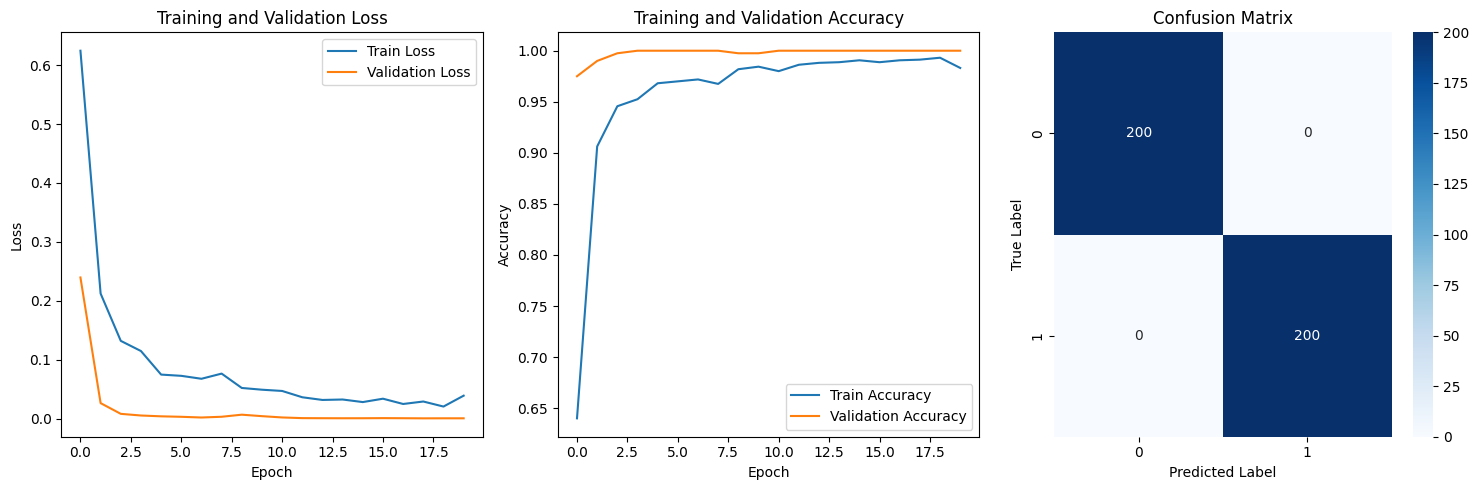


Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       200
        Fake       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Training script completed successfully!
Check the results in: /content/drive/MyDrive/deepfake_detection/results/
Best model saved at: /content/drive/MyDrive/deepfake_detection/models/best_model.pth


In [ ]:
if __name__ == "__main__":
    print("Starting Deepfake Detection Model Training")
    print("=" * 60)

    # Run main training function
    model, train_losses, val_losses, train_accs, val_accs = main()

    print("\nTraining script completed successfully!")
    print("Check the results in:", f'{base_dir}/results/')
    print("Best model saved at:", f'{base_dir}/models/best_model.pth')